In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf

# <font face="gotham" color="purple"> Techniques For Handling Time Series Data </font>

This section aims to introduce the most fundamental skills of wrangling time series data in Python, specifically with Pandas.

## <font face="gotham" color="purple"> Why Taking Logs?</font>

If the time series that exhibit any traces of growth or decline, i.e. nonstationary, a useful transformation is to take natural logarithm of it. Suppose if $y_t$ is an observation of the time series in period $t$, the growth rate from period $t-1$ is
$$
g_t = \frac{y_t}{y_{t-1}}-1
$$
where $g_t$ is the growth rate. Rearrange and take natural log
$$
\ln{(1+g_t)}=\ln{\bigg(\frac{y_t}{y_{t-1}}\bigg)}=\ln{y_t}-\ln{y_{t-1}}
$$
So the question is what is $\ln{(1+g_t)}$?

In calculus class, we have learned **Taylor Expansion**, which is the ultimate weapon for approximate any functions. 
$$
\ln (1+x)=x-\frac{1}{2} x^{2}+\frac{1}{3} x^{3}-\frac{1}{4} x^{4}+\ldots=\sum_{k=1}^\infty(-1)^{k+1}\frac{x^k}{k}
$$

Because the growth rate is usually small, we can use the linear term exclusively in Taylor expansion
$$
\ln{(1+x)}\approx x
$$
which means log difference approximates the growth rate
$$
\ln{y_t}-\ln{y_{t-1}} \approx g_t
$$

Let's take a look at real GDP per capita from US.

In [2]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2021, 10, 1)
df = pdr.data.DataReader(["A939RX0Q048SBEA"], "fred", start, end)
df.columns = ["R_GDP_PerCap"]
df["R_GDP_PerCap_tm1"] = df["R_GDP_PerCap"].shift(1)
df = df.dropna()
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1
DATE,,
1950-04-01,15977.0,15559.0
1950-07-01,16524.0,15977.0
1950-10-01,16764.0,16524.0
1951-01-01,16922.0,16764.0
1951-04-01,17147.0,16922.0


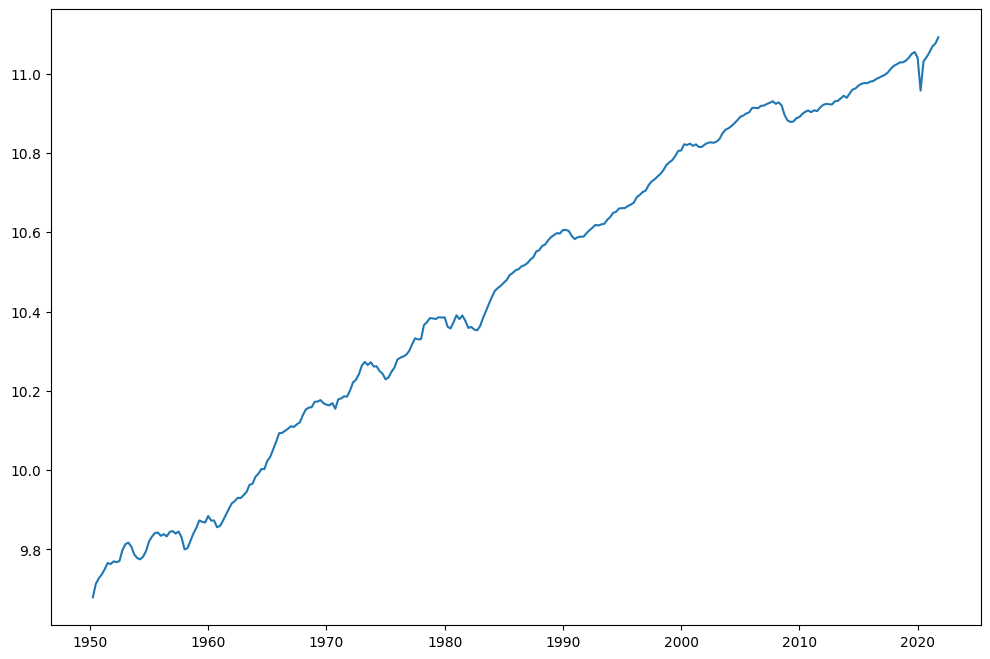

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.log(df["R_GDP_PerCap"]))
plt.show()

In [4]:
pd.options.mode.chained_assignment = None  # without this, there will be error msg 'A value is trying to be set on a copy of a slice from a DataFrame.'
df["Gr_rate"] = df["R_GDP_PerCap"] / df["R_GDP_PerCap_tm1"]
df["Gr_rate"] = df["Gr_rate"] - 1
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate
DATE,,,
1950-04-01,15977.0,15559.0,0.026865
1950-07-01,16524.0,15977.0,0.034237
1950-10-01,16764.0,16524.0,0.014524
1951-01-01,16922.0,16764.0,0.009425
1951-04-01,17147.0,16922.0,0.013296


In [5]:
df["Gr_rate_log_approx"] = np.log(df["R_GDP_PerCap"]) - np.log(df["R_GDP_PerCap_tm1"])
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx
DATE,,,,
1950-04-01,15977.0,15559.0,0.026865,0.026511
1950-07-01,16524.0,15977.0,0.034237,0.033664
1950-10-01,16764.0,16524.0,0.014524,0.014420
1951-01-01,16922.0,16764.0,0.009425,0.009381
1951-04-01,17147.0,16922.0,0.013296,0.013209


This charts shows the difference between division growth rate $g_t = \frac{y_t}{y_{t-1}}-1$ and log difference growth rate $g_t\approx \ln{y_t}-\ln{y_{t-1}} $

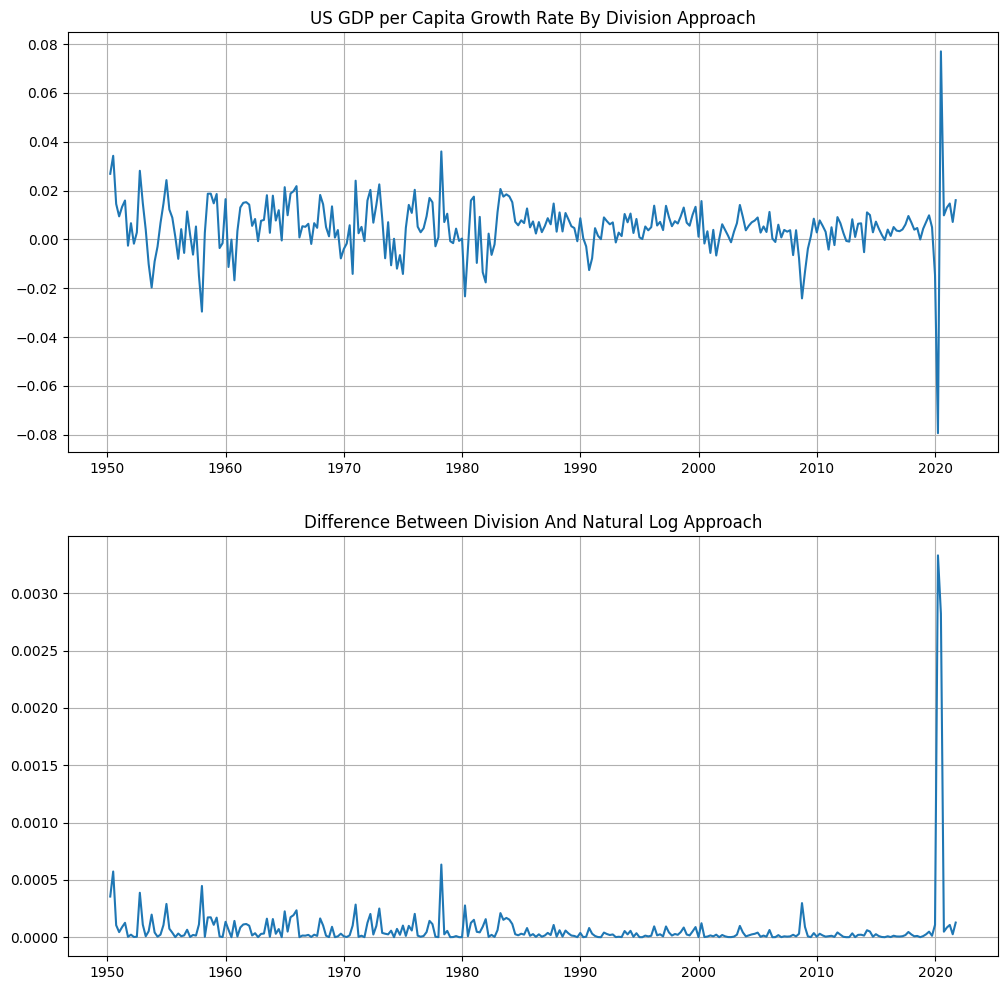

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].plot(df["Gr_rate"])
ax[0].grid()
ax[0].set_title("US GDP per Capita Growth Rate By Division Approach")
ax[1].plot(df["Gr_rate"] - df["Gr_rate_log_approx"])
ax[1].grid()
ax[1].set_title("Difference Between Division And Natural Log Approach")
plt.show()

In [7]:
max(df["Gr_rate"])

0.07702629698691243

In [8]:
max(df["Gr_rate_log_approx"])

0.07420381476280546

As you can see from log difference growth rate will consistently underestimate the growth rate, however the differences are negligible, mostly difference are under $5$ basis points, especially post 1980s period, the log difference grow rate approximate real growth rate considerably well. The only exception is the rebound during Covid pandemic, more than $40$ basis points ($0.04\%$).

## <font face="gotham" color="purple"> How Reliable Is The Natural Log Transformation?</font>

We create a series from $0$ to $.8$ with step of $.01$, which means the growth rate ranging from $0\%$ to $80
\%$ with step of $1\%$. The first plot is the comparison of division and natural log approach, as they increase the discrepancy grow bigger too, the second plot is the difference of two approaches, if the growth rate is less than $20\%$, the error of natural log approach is acceptable.

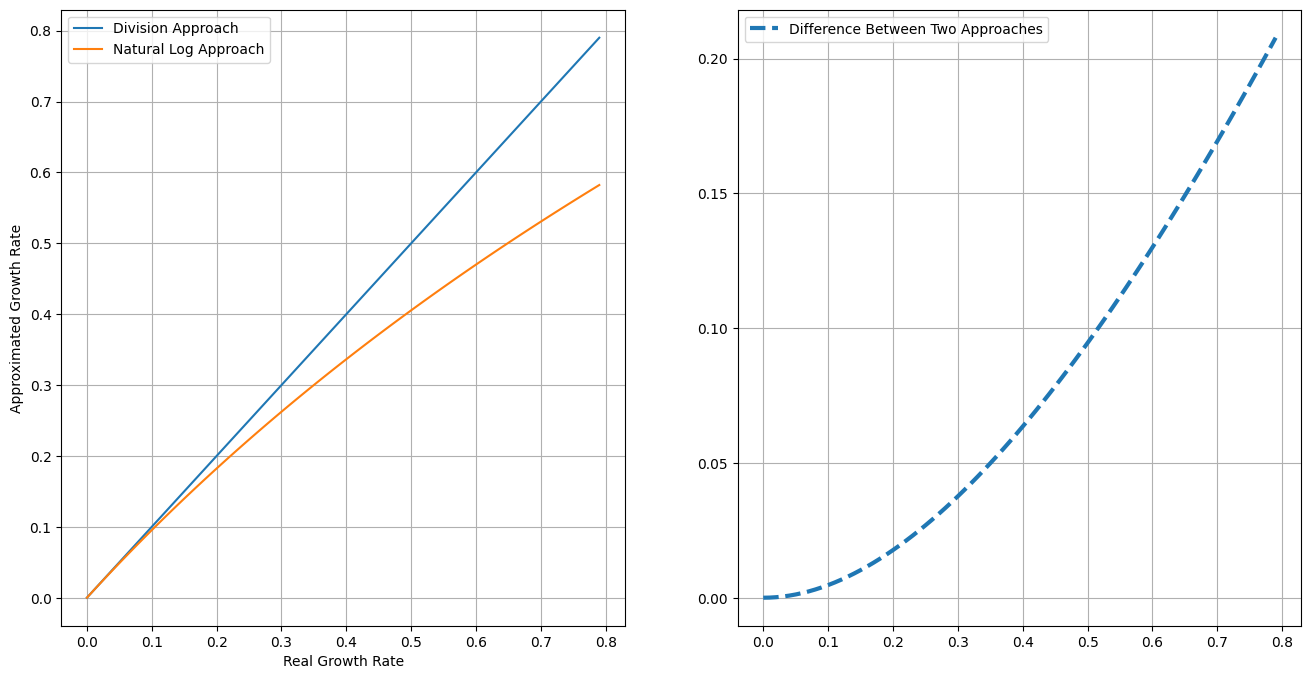

In [9]:
g = np.arange(0, 0.8, 0.01)
log_g = np.log(1 + g)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].plot(g, g, label="Division Approach")
ax[0].plot(g, log_g, label="Natural Log Approach")
ax[0].set_xlabel("Real Growth Rate")
ax[0].set_ylabel("Approximated Growth Rate")
ax[0].grid()
ax[0].legend()

ax[1].plot(g, g - log_g, ls="--", lw=3, label="Difference Between Two Approaches")
ax[1].grid()
ax[1].legend()
plt.show()

## <font face="gotham" color="purple"> How To Calculate YoY growth rate? </font>

What we have seen above is **Quarter on Quarter** (QoQ) growth rate, another common way of measuring growth is **Year over Year**. 

If you still using quarterly data, it's simply 
$$
g_{YoY, 2021}=\frac{y_{3Q2021}}{y_{3Q2020}}-1
$$
where $y_{3Q2021}$ is the observation on the $3$rd quarter of $2021$, similarly $y_{3Q2020}$ is from the $3$rd quarter of $2020$.

In [10]:
df["R_GDP_PerCap_tm4"] = df["R_GDP_PerCap"].shift(4)
df = df.dropna()
df

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4
DATE,,,,,
1951-04-01,17147.0,16922.0,0.013296,0.013209,15977.0
1951-07-01,17420.0,17147.0,0.015921,0.015796,16524.0
1951-10-01,17375.0,17420.0,-0.002583,-0.002587,16764.0
1952-01-01,17490.0,17375.0,0.006619,0.006597,16922.0
1952-04-01,17459.0,17490.0,-0.001772,-0.001774,17147.0
...,...,...,...,...,...
2020-10-01,62411.0,61803.0,0.009838,0.009790,63257.0
2021-01-01,63224.0,62411.0,0.013027,0.012942,62333.0
2021-04-01,64153.0,63224.0,0.014694,0.014587,57383.0


In [11]:
df["Gr_rate_log_approx_YoY"] = np.log(df["R_GDP_PerCap"]) - np.log(
    df["R_GDP_PerCap_tm4"]
)
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4,Gr_rate_log_approx_YoY
DATE,,,,,,
1951-04-01,17147.0,16922.0,0.013296,0.013209,15977.0,0.070673
1951-07-01,17420.0,17147.0,0.015921,0.015796,16524.0,0.052805
1951-10-01,17375.0,17420.0,-0.002583,-0.002587,16764.0,0.035799
1952-01-01,17490.0,17375.0,0.006619,0.006597,16922.0,0.033015
1952-04-01,17459.0,17490.0,-0.001772,-0.001774,17147.0,0.018032


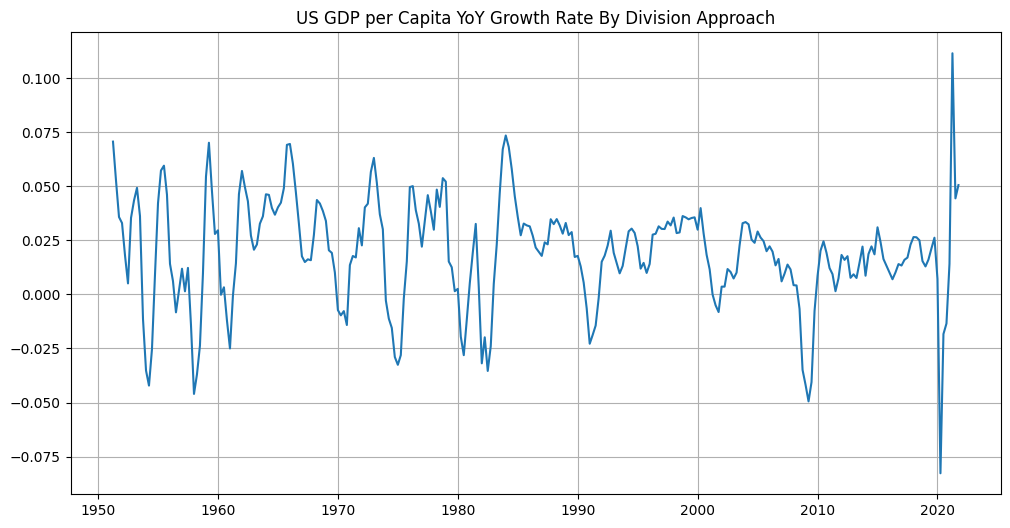

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Gr_rate_log_approx_YoY"])
ax.grid()
ax.set_title("US GDP per Capita YoY Growth Rate By Division Approach")
plt.show()

## <font face="gotham" color="purple"> How to Resample Time Series? </font>

By **resampling**, we can **upsample** the series, i.e. convert to higher frequency series, or we can **downsample** the series, i.e. convert to lower frequency series.

For example, you have one series of lower frequency, say annually, but the rest of series are quarterly, in order to incorporate this annual series into the whole dataset, we have to upsample it to quarterly data.

Now we import nominal annual GDP per capita.

In [13]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2021, 10, 1)
df = pdr.data.DataReader(["A939RC0A052NBEA"], "fred", start, end)
df.columns = ["Nom_GDP_PerCap_Annual"]
df = df.dropna()
df.head()

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.0
1951-01-01,2248.0
1952-01-01,2340.0
1953-01-01,2439.0
1954-01-01,2405.0


In [14]:
df_us_Q = df.resample("QS").interpolate(method="linear")  # QS mean quarter start freq
df_us_Q.head()

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.00
1950-04-01,2044.75
1950-07-01,2112.50
1950-10-01,2180.25
1951-01-01,2248.00


To downsample a series, e.g. to convert daily series into a monthly series

In [15]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021, 10, 1)
df = pdr.data.DataReader(["DEXCHUS"], "fred", start, end)
df.columns = ["USDCNY"]
df = df.dropna()
df.head()

,USDCNY
DATE,
2010-01-04,6.8273
2010-01-05,6.8258
2010-01-06,6.8272
2010-01-07,6.8280
2010-01-08,6.8274


In [16]:
df_M = df.resample("M").mean()
df_M.head()

/tmp/ipykernel_190154/2522482061.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_M = df.resample("M").mean()


,USDCNY
DATE,
2010-01-31,6.826916
2010-02-28,6.828463
2010-03-31,6.826183
2010-04-30,6.825550
2010-05-31,6.827450


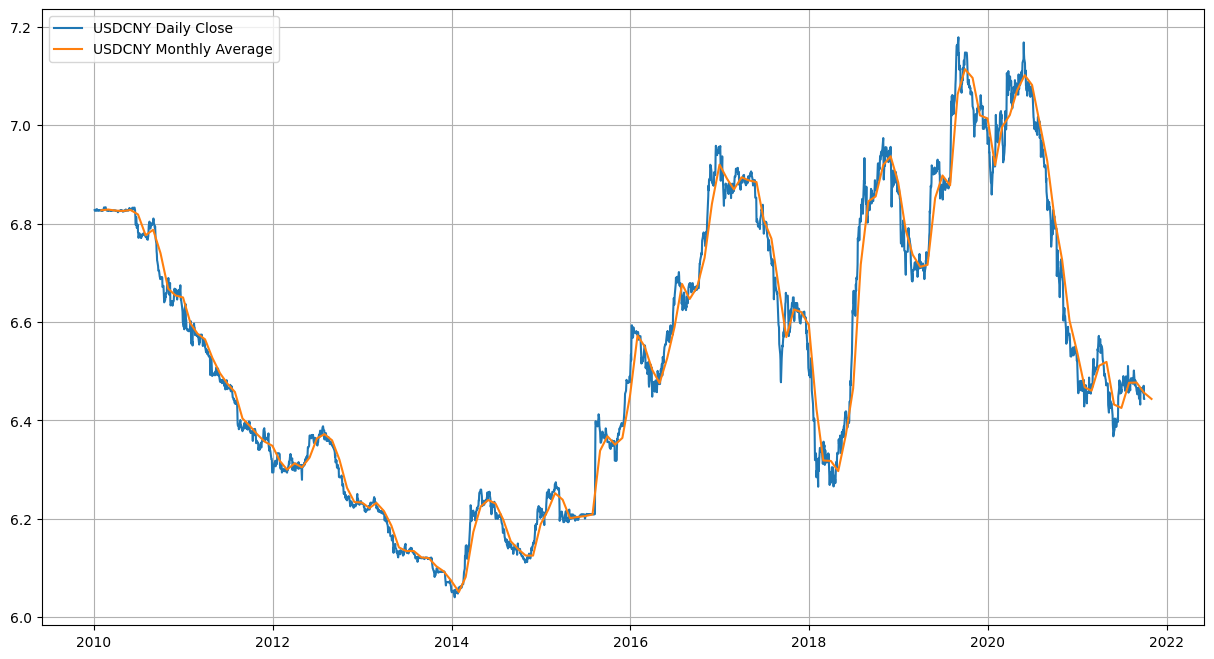

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df["USDCNY"], label="USDCNY Daily Close")
ax.plot(df_M["USDCNY"], label="USDCNY Monthly Average")
ax.grid()
ax.legend()
plt.show()

Here's the full list of frequency supported by Pandas.

```
B         business day frequency
C         custom business day frequency (experimental)
D         calendar day frequency
W         weekly frequency
M         month end frequency
SM        semi-month end frequency (15th and end of month)
BM        business month end frequency
CBM       custom business month end frequency
MS        month start frequency
SMS       semi-month start frequency (1st and 15th)
BMS       business month start frequency
CBMS      custom business month start frequency
Q         quarter end frequency
BQ        business quarter endfrequency
QS        quarter start frequency
BQS       business quarter start frequency
A         year end frequency
BA, BY    business year end frequency
AS, YS    year start frequency
BAS, BYS  business year start frequency
BH        business hour frequency
H         hourly frequency
T, min    minutely frequency
S         secondly frequency
L, ms     milliseconds
U, us     microseconds
N         nanoseconds
```

## <font face="gotham" color="purple"> Detrend </font>

The most common tool of detrending in applied macroeconomics is **Hodrick-Prescott filter**, we assume a time series $y_t$ can be decomposed into
$$
y_t = \tau_t+c_t
$$
where $\tau$ is trend and $c$ is cyclical components.

Trend component minimize objective function over $\tau$'s
$$
\min _{\tau}\left(\sum_{t=1}^{T}\left(y_{t}-\tau_{t}\right)^{2}+\lambda \sum_{t=2}^{T-1}\left[\left(\tau_{t+1}-\tau_{t}\right)-\left(\tau_{t}-\tau_{t-1}\right)\right]^{2}\right)
$$

Academically, $\lambda$ is suggested to take three distinct values: 
\begin{align}
&\text{Annual}: 6.25 \\
&\text{Quarter}: 1600\\
&\text{Month}: 129600
\end{align}

However, you can always break these rules, especially in high frequency data.

In [18]:
USDCNY_cycle, USDCNY_trend = hpfilter(np.log(df["USDCNY"]), lamb=10000000)

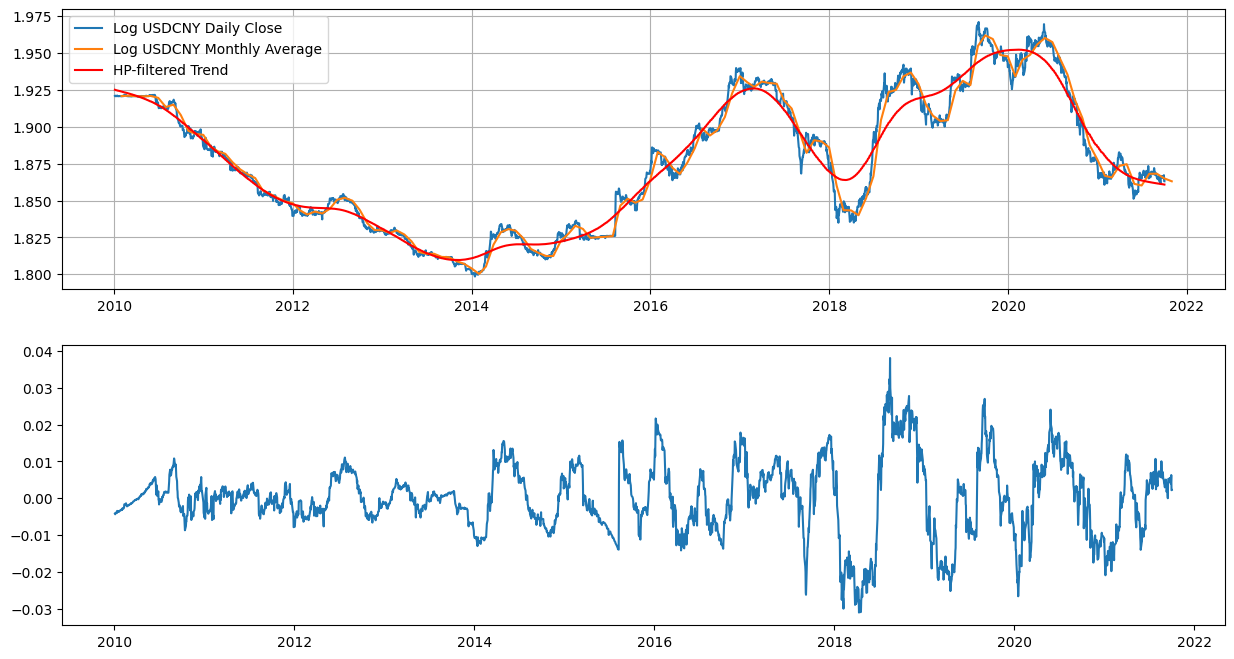

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
ax[0].plot(np.log(df["USDCNY"]), label="Log USDCNY Daily Close")
ax[0].plot(np.log(df_M["USDCNY"]), label="Log USDCNY Monthly Average")
ax[0].plot(USDCNY_trend, color="red", label="HP-filtered Trend")
ax[0].grid()
ax[0].legend()

ax[1].plot(USDCNY_cycle, label="HP-filtered Cycle")
plt.show()

# <font face="gotham" color="purple"> Dynamic Econometric Models </font>

After discussions of autocorrelation, we are officially entering the realm of time series econometrics. For starter, we will discuss dynamic econometric models: **distributed-lag model** and **autogressive model**. 

In economics and finance, dependent variables and explanatory (independent) variables are rarely instantaneous, i.e. $Y$ responds to $X$'s with a lapse of time.

## <font face="gotham" color="purple"> Distributed-Lag Model (DLM) </font>

Here is a DLM with one explanatory variable $X$
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{1} X_{t-1}+\beta_{2} X_{t-2}+\cdots+u_{t}
$$

### <font face="gotham" color="purple"> Ad Hoc Estimation Of DLM </font>

If you are estimating variables which have no clear economic relationship or no well-founded theoretical support, go with ad hoc estimation method. 

So you start regressing $X_t$ onto $Y_t$, then adding $X_{t-i}$ where $i \geq 1$ in each round of regression, until $t$-statistic starting to be insignificant or signs of coefficients start to be unstable.

\begin{align}
\hat{Y}_t &= a + b_0X_t\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_2X_{t-2}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_1X_{t-1}+b_3X_{t-3}\\
\end{align}

But be aware that ad hoc method is bring significant problem of multicollinearity. 

### <font face="gotham" color="purple"> Koyck Approach To DLM </font>

Koyck approach assumes that all $\beta$'s are of the same sign, furthermore
$$
\beta_{k}=\beta_{0} \lambda^{k} \quad k=0,1, \ldots
$$
where $\lambda$ is the _rate of decay_, $0<\lambda<1$.

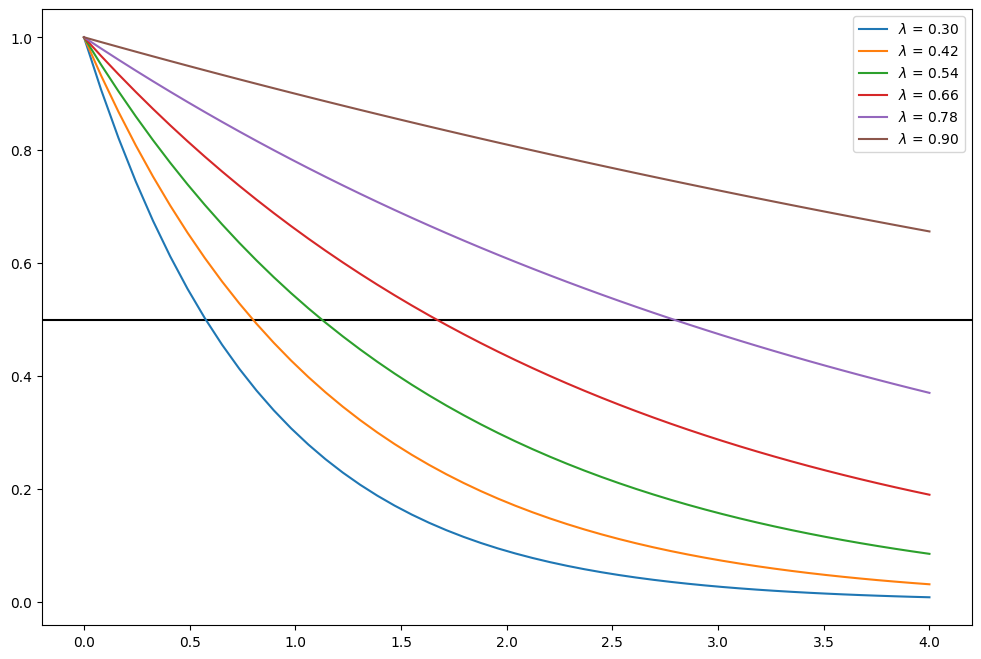

In [20]:
lamda = np.linspace(0.3, 0.9, 6)
beta_0 = 1
k = np.linspace(0, 4)
fig, ax = plt.subplots(figsize=(12, 8))
for i in lamda:
    beta_k = beta_0 * i**k
    ax.plot(k, beta_k, label="$\lambda$ = %.2f" % i)
ax.legend()
ax.axhline(y=0.5, zorder=-10, color="k")
plt.show()

There are three perks of Koyck approach:

1. By assuming nonnegative values for $λ$, $\beta$'s sign are stable; 
2. by assuming $λ < 1$, lesser weight is given to the distant $β$'s than the current ones; 
3. The sum of the $β$'s, which gives the long-run multiplier, is finite, i.e.
$$
\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)
$$

Naturally, the infinite distributed lag  model can be rewritten as
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{0} \lambda X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\cdots+u_{t}
$$

Lag both sides one period
$$
Y_{t-1}=\alpha+\beta_{0} X_{t-1}+\beta_{0} \lambda X_{t-2}+\beta_{0} \lambda^{2} X_{t-3}+\cdots+u_{t-1}
$$

Multiply by $\lambda$
$$
\lambda Y_{t-1}=\lambda \alpha+\lambda \beta_{0} X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\beta_{0} \lambda^{3} X_{t-3}+\cdots+\lambda u_{t-1}
$$
Join with original equation
$$
Y_{t}-\lambda Y_{t-1}=\alpha(1-\lambda)+\beta_{0} X_{t}+\left(u_{t}-\lambda u_{t-1}\right)
$$

Rearrange, we obtain
$$
Y_{t}=\alpha(1-\lambda)+\beta_{0} X_{t}+\lambda Y_{t-1}+v_{t}
$$
where $v_t = (u_t − λu_{t−1})$.

This is called **Koyck transformation** which simplifies original infinite DLM into an $AR(1)$.

### <font face="gotham" color="purple"> An Example Of Consumption And Income </font>

We import macro data from FRED, $PCE$ is _real personal consumption expenditure_ and $DI$ is _real disposable income per capita_. 

In [21]:
start = dt.datetime(2002, 1, 1)
end = dt.datetime(2021, 10, 1)
df_exp = pdr.data.DataReader(["PCEC96", "A229RX0"], "fred", start, end)
df_exp.columns = ["PCE", "DI"]
df_exp = df_exp.dropna()
df_exp.head()

,PCE,DI
DATE,,
2007-01-01,11181.0,39803.0
2007-02-01,11178.2,39906.0
2007-03-01,11190.7,40007.0
2007-04-01,11201.5,40037.0
2007-05-01,11218.0,40029.0


Define a function for lagging, which is handy in $R$-style formula.

In [22]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n)
    else:
        x = pd.Series(x)
        return x.shift(n)
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

The model is 
$$
PCE_t = \alpha(1-\lambda) + \beta_0 DI_t + \lambda PCE_{t-1}+ v_t
$$

In [23]:
DLM = smf.ols(formula="PCE ~ 1 + lag(DI, 0) + lag(PCE, 1)", data=df_exp)
DLM_results = DLM.fit()
print(DLM_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     3798.
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          2.88e-144
Time:                        18:56:51   Log-Likelihood:                -1155.7
No. Observations:                 177   AIC:                             2317.
Df Residuals:                     174   BIC:                             2327.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -113.0613    150.246     -0.753      

The estimated results:

In [24]:
beta_0 = DLM_results.params[1]
lamda = DLM_results.params[2]
alpha = DLM_results.params[0] / (1 - DLM_results.params[2])

print("beta_0 = {}".format(beta_0))
print("lambda = {}".format(lamda))
print("alpha = {}".format(alpha))

beta_0 = 0.020979751201760436
lambda = 0.9375150192010723
alpha = -1809.415914863202


/tmp/ipykernel_190154/3362829195.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_0 = DLM_results.params[1]
/tmp/ipykernel_190154/3362829195.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lamda = DLM_results.params[2]
/tmp/ipykernel_190154/3362829195.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = DLM_results.params[0] / (1 - DLM_results.params[2])


Any $\beta_k$ is given by $\beta_{k}=\beta_{0} \lambda^{k}$

In [25]:
def beta_k(lamda, k, beta_0):
    return beta_0 * lamda**k

In [26]:
beta_k(lamda, 1, beta_0)

0.019668831850752154

The long run multiplier given by $\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)$

In [27]:
beta_0 * (1 / (1 - lamda))

0.3357567039873438

In [28]:
1 / (1 - lamda)

16.00384583965753

Median lag, the lags that it takes to decay the first half. From our example, that $PCE$ adjusts to $DI$ with substantial lag, around $9$ month to have half impact.

In [29]:
-np.log(2) / np.log(lamda)

10.742720324376041

Mean lag

In [30]:
lamda / (1 - lamda)

15.003845839657528

# <font face="gotham" color="purple"> Stochastic Processes </font>

Unstrictly speaking, **stochastic processes** is a subject of mathematics that studies a family of random variables which are indexed by time. Since time series data is a series of **realization** of a stochastic process, before investigating further, we will introduce some basic concepts of stochastic processes.

For instance, we denote $GDP$ as $Y_t$ which is a stochastic process, therefore $Y_1$ and $Y_2$ are two different random variables, if $Y_1 = 12345$, then it is a realization of $t_1$. You can think of stochastic process as population and realization as sample as in cross-sectional data.

## <font face="gotham" color="purple"> Stationary Stochastic Processes </font>

A stochastic process is said to be **stationary** if its mean and variance are constant over time and the value of the covariance between the two time periods depends only on the distance $k$ between the two time periods and not the actual time at which the covariance is computed. Mathematically, a **weak stationary process** should satisfy three conditions:

\begin{align}
Mean:& \quad E\left(Y_{t}\right)=\mu\\
Variance:&\quad E\left(Y_{t}-\mu\right)^{2}=\sigma^{2}\\
Covariance:&\quad E\left[\left(Y_{t}-\mu\right)\left(Y_{t+k}-\mu\right)\right] = \gamma_{k}
\end{align}

Most of time weak stationary process will suffice, rarely we require a process to be **strong stationary** which means all moments are **time-invariant**. A common feature of _time-invariant_ time series is **mean reversion**.

Why do we care about _stationarity_? 

If a time series is nonstationary, we can only study the behavior in a particular episode and the outcomes can't be generalized to other episodes. Therefore forecasting nonstationary time series would absolutely be of little value.

## <font face="gotham" color="purple"> Nonstationary Stochastic Processes </font>

The most common type of nonstationary process is **random walk**, and two subtypes are demonstrated below: **with**/**without drift**.

### <font face="gotham" color="purple"> Random Walk With Drift </font>

A random walk without drift can be modeled with a $AR(1)$ where $\rho=1$ and constant term is $0$
$$
Y_t = Y_{t-1}+u_t
$$
The mean and variance can be shown
\begin{align}
E\left(Y_{t}\right)&=E\left(Y_{0}+\sum u_{t}\right)=Y_{0}\\
\operatorname{Var}\left(Y_{t}\right)&=t \sigma^{2}
\end{align}
There are lots of financial time series resemble random walk process, for example, we will generate a random walk with the same length of $EURUSD$, let's see if you can visually differentiate them

In [31]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2021, 10, 1)
df_eurusd = pdr.data.DataReader(["DEXUSEU"], "fred", start, end)
df_eurusd.columns = ["EURUSD"]
df_eurusd = df_eurusd.dropna()

In [32]:
def rw_wdr(init_val, length):
    rw_array = []
    rw_array.append(init_val)

    last = init_val
    for i in range(length):
        current = last + np.random.randn() / 100
        rw_array.append(current)
        last = current
    return rw_array

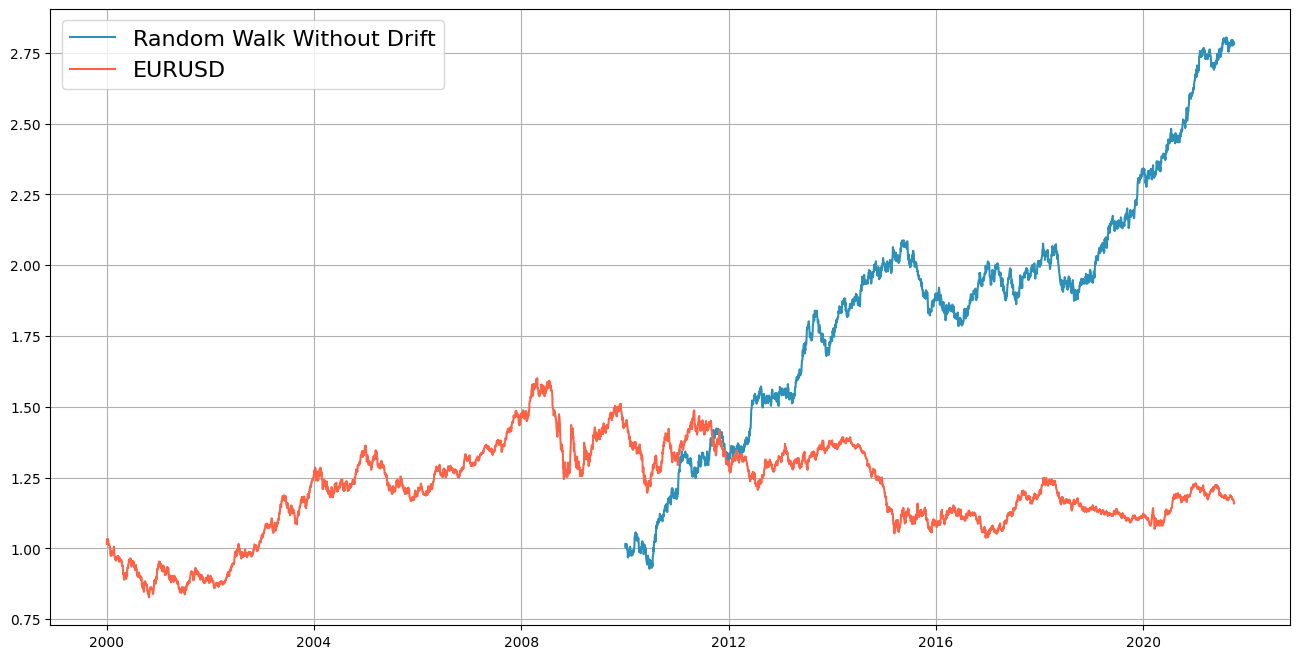

In [33]:
rw = rw_wdr(1.0155, len(df.index) - 1)
df_rw = pd.DataFrame(rw, index=df.index, columns=["Simulated Asset Price"])
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_rw, color="#2c90b8", label="Random Walk Without Drift")
ax.plot(df_eurusd, color="tomato", label="EURUSD")
ax.grid()
ax.legend(fontsize=16)
plt.show()

First order difference of random walk is stationary.

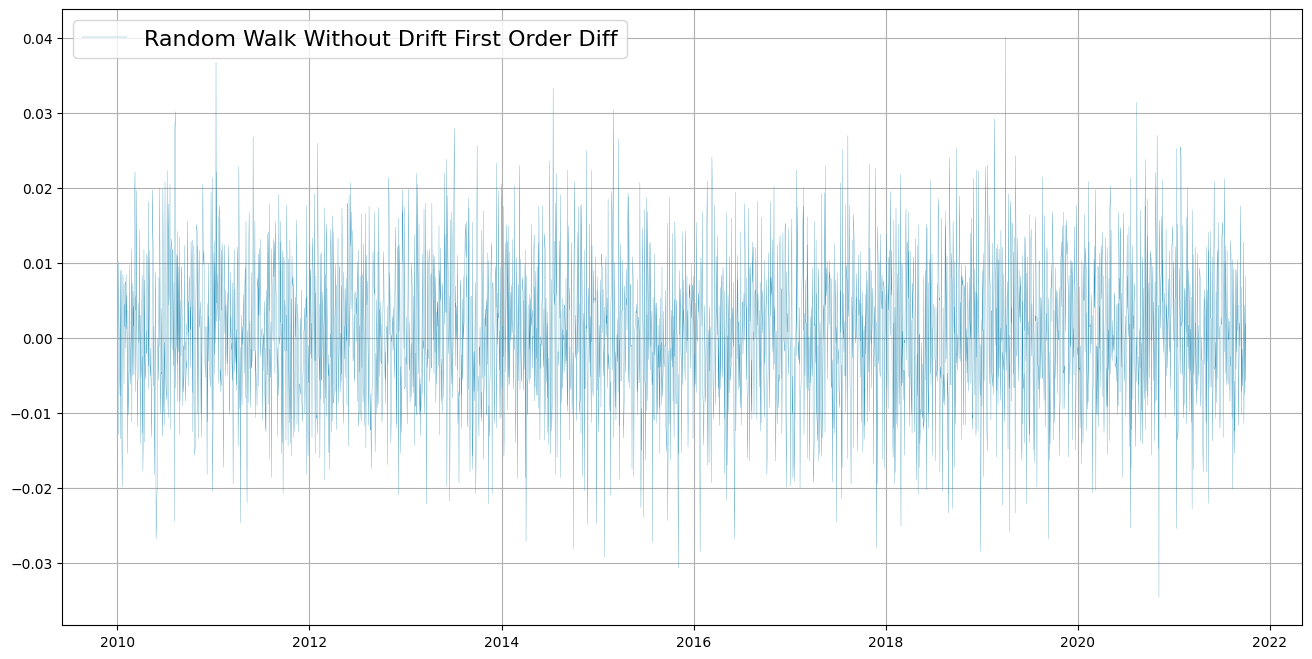

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(
    df_rw.diff().dropna(),
    color="#2c90b8",
    label="Random Walk Without Drift First Order Diff",
    lw=0.2,
)
ax.grid()
ax.legend(fontsize=16)
plt.show()

Note that if we rewrite the model
$$
\Delta Y_{t}=\left(Y_{t}-Y_{t-1}\right)=u_{t}
$$
it becomes stationary, hence it is **difference stationary process** (DSP).

### <font face="gotham" color="purple"> Random Walk With Drift </font>

Random walk with drift can be modeled by
$$
Y_{t}=\delta+Y_{t-1}+u_{t}
$$
And mean and variance are
\begin{aligned}
E\left(Y_{t}\right) &=Y_{0}+t \cdot \delta \\
\operatorname{Var}\left(Y_{t}\right) &=t \sigma^{2}
\end{aligned}

In [35]:
def rw_dr(dr_param, init_val, length):
    rw_array = []
    rw_array.append(init_val)

    last = init_val
    for i in range(length):
        current = dr_param + last + 50 * np.random.randn()
        rw_array.append(current)
        last = current
    return rw_array

In [36]:
rw = rw_dr(5, 1, len(df.index) - 1)

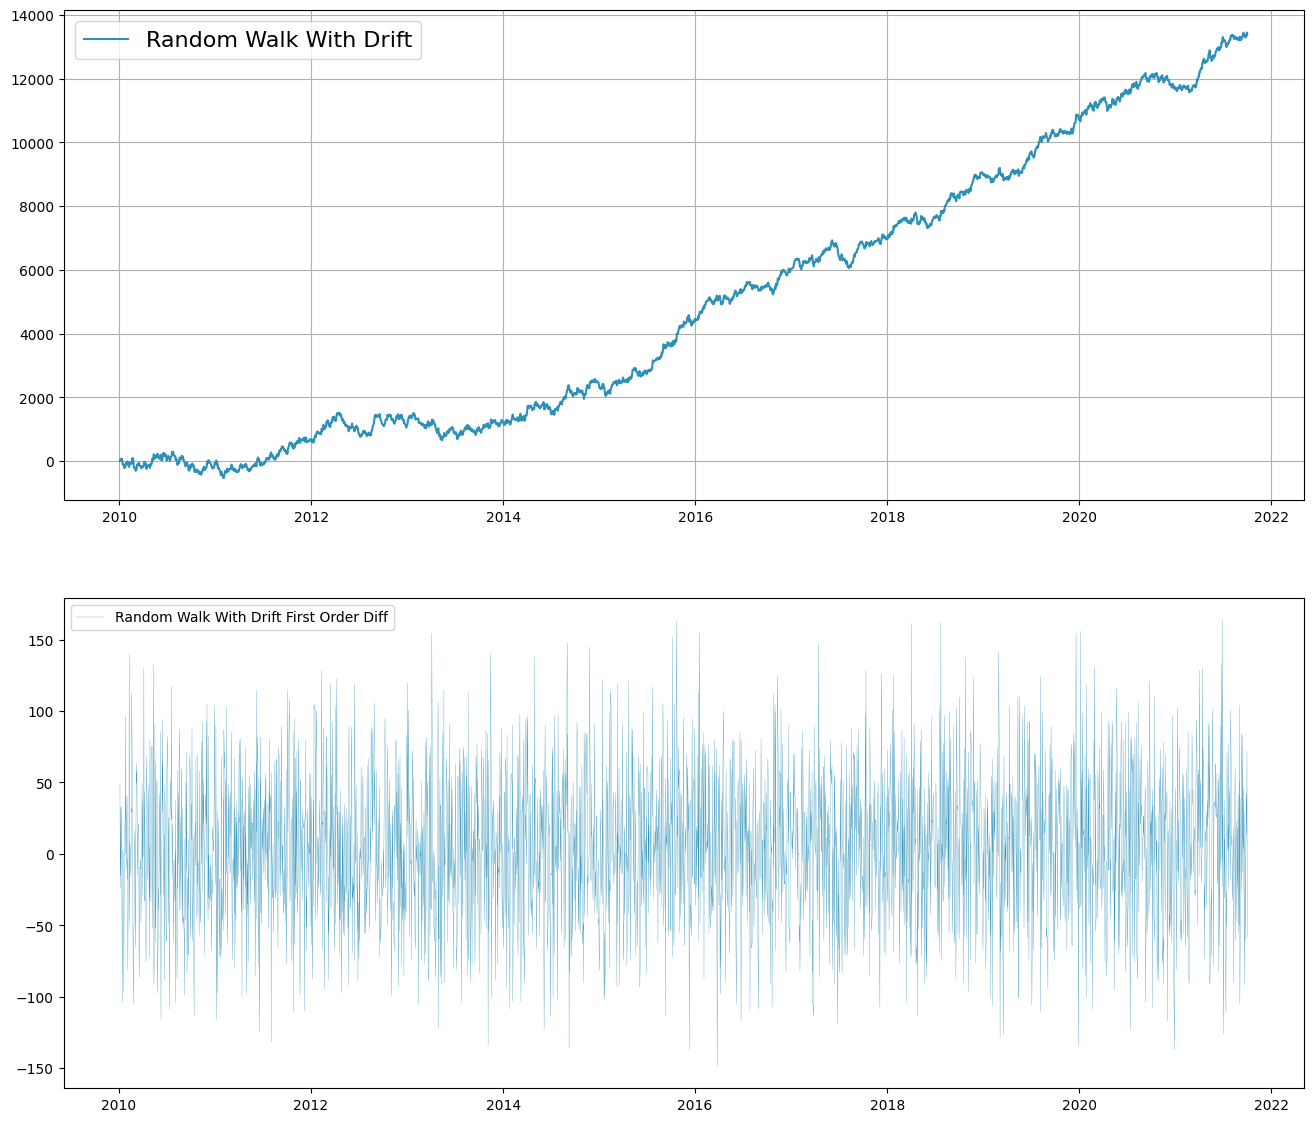

In [37]:
df_rw = pd.DataFrame(rw, index=df.index, columns=["Simulated Asset Price"])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 14))
ax[0].plot(df_rw, color="#2c90b8", label="Random Walk With Drift")
ax[1].plot(
    df_rw.diff().dropna(),
    color="#2c90b8",
    label="Random Walk With Drift First Order Diff",
    lw=0.2,
)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[1].legend()
plt.show()

As long as $\rho=1$, we call it **unit root problem**, thus the terms nonstationarity, random walk, unit root, and stochastic trend can be treated synonymously.

If we rewrite the model
$$
\left(Y_{t}-Y_{t-1}\right)=\Delta Y_{t}=\beta_{1}+u_{t}
$$

which is also a DSP, however if $\beta\neq 0$, the first difference exhibits a positive or negative trend, which is called **stochastic trend**.

### <font face="gotham" color="purple"> Trend Stationary Process </font>

Consider the model
$$
Y_{t}=\beta_{1}+\beta_{2} t+u_{t}
$$
If we subtract $E(Y_t)$ from $Y_t$, resulting series will be stationary, hence it is **trend stationary process** (TSP). Deterministic trend with $AR(1)$ component
$$
Y_{t}=\beta_{1}+\beta_{2} t+\beta_{3} Y_{t-1}+u_{t}
$$

## <font face="gotham" color="purple"> Integrated Stochastic Processes </font>

Any time series, after a first order difference, becomes stationary, we call it **integrated of order 1** denoted $Y_t\sim I(1)$. If a time series has to be differenced twice to be stationary, we call such time series **integrated of order 2** denoted  $Y_t\sim I(2)$. 

Most of economic and financial time series are $I(1)$. 

### <font face="gotham" color="purple"> Properties of Integrated Series </font>

1. If $X_{t} \sim I(0)$ and $Y_{t} \sim I(1)$, then $Z_{t}=\left(X_{t}+Y_{t}\right)=I(1)$
2. If $X_{t} \sim I(d)$, then $Z_{t}=\left(a+b X_{t}\right)=I(d)$, where $a$ and $b$ are constants.  Thus, if $X_{t} \sim I(0)$, then $Z_{t}=$ $\left(a+b X_{t}\right) \sim I(0)$
3. If $X_{t} \sim I\left(d_{1}\right)$ and $Y_{t} \sim I\left(d_{2}\right)$, then $Z_{t}=\left(a X_{t}+b Y_{t}\right) \sim I\left(d_{2}\right)$, where $d_{1}<d_{2}$
4. If $X_{t} \sim I(d)$ and $Y_{t} \sim I(d)$, then $Z_{t}=\left(a X_{t}+b Y_{t}\right) \sim I\left(d^{*}\right) ; d^{*}$ is generally equal to $d$, but in some cases $d^{*}<d$

## <font face="gotham" color="purple"> Spurious Regression </font>

The best way to understand **spurious regression** is to generate two random walk series then regression one onto the other. Let's simulate two assets' price $Y_t$ and $X_t$

\begin{aligned}
Y_{t} &= \alpha_1+\alpha_2 Y_{t-1}+u_{t} \\
X_{t} &=\beta_1+\beta_2 X_{t-1}+v_{t}
\end{aligned}

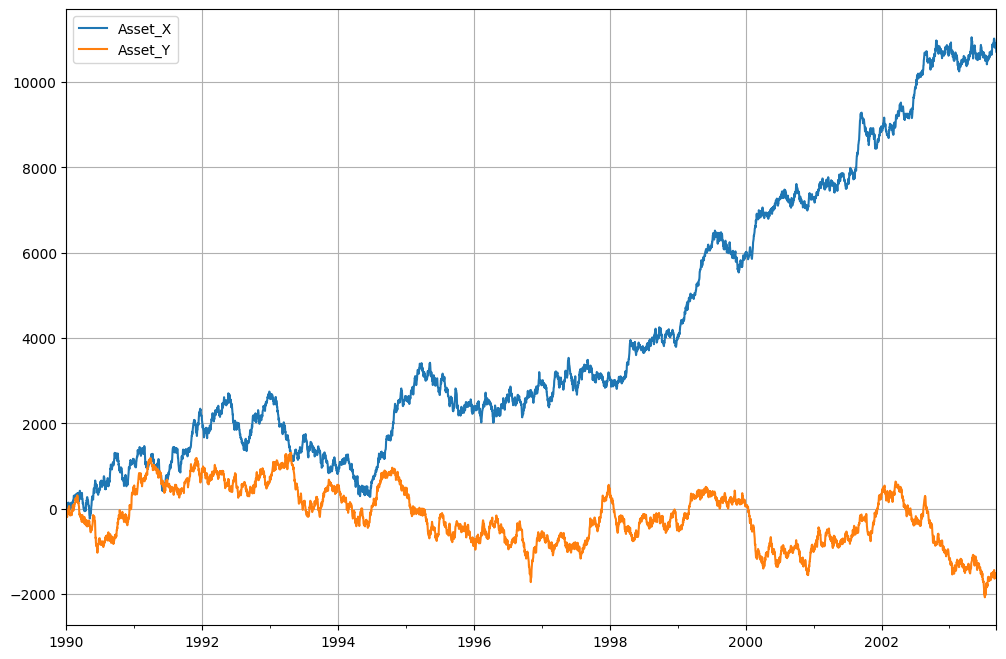

In [38]:
def rw_dr(dr_param, slope_param, init_val, length):
    rw_array = []
    rw_array.append(init_val)

    last = init_val
    for i in range(length):
        current = dr_param + slope_param * last + 50 * np.random.randn()
        rw_array.append(current)
        last = current
    return rw_array


N = 5000
X = rw_dr(2, 1, 0, N)
Y = rw_dr(0, 1, 0, N)
dates = pd.date_range("19900101", periods=N + 1)

df = pd.DataFrame([X, Y]).T
df.columns = ["Asset_X", "Asset_Y"]
df.index = dates
df.plot(figsize=(12, 8), grid=True)
plt.show()

In [39]:
model = smf.ols(formula="Asset_Y ~ Asset_X", data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Asset_Y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     1483.
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          2.40e-284
Time:                        18:56:56   Log-Likelihood:                -38981.
No. Observations:                5001   AIC:                         7.797e+04
Df Residuals:                    4999   BIC:                         7.798e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    220.9304     13.632     16.207      0.0

Note that $t$-statistic of $X$ is highly significant, and $R^2$ is relatively low though $F$-statistic extremely significant. You will see different results when running codes on your computer, because I didn't set random seeds in Python.

We know the data generating processes of $X$ and $Y$ are absolutely irrelevant, but regression results say otherwise. This a **phenomenon of spurious regression**. You can see the $dw$ is almost $0$, which signals strong autocorrelation issue.

An $R^2 > dw$ is a good rule of thumb to suspect that the estimated regression is spurious. Also note that all statistic tests are invalid because $t$-statistics are not distributed as $t$-distribution.

## <font face="gotham" color="purple"> Tests Of Stationarity </font>

### <font face="gotham" color="purple"> Autocorrelation Function And Correlogram </font>

Autocorrelation function (ACF) at lag $k$ is defined as 
\begin{aligned}
\rho_{k} &=\frac{\gamma_{k}}{\gamma_{0}}=\frac{\text { covariance at lag } k}{\text { variance }}
\end{aligned}
In practice, we can only compute **sample autocorrelation function**, $\hat{\rho}_k$
\begin{aligned}
&\hat{\gamma}_{k}=\frac{\sum\left(Y_{t}-\bar{Y}\right)\left(Y_{t+k}-\bar{Y}\right)}{n-k} \\
&\hat{\gamma}_{0}=\frac{\sum\left(Y_{t}-\bar{Y}\right)^{2}}{n-1}
\end{aligned}
Note that $\hat{\rho}_0 = 1$.

If we plot $\hat{\rho}$ against $k$, we obtain correlogram, here is a correlogram of a white noise

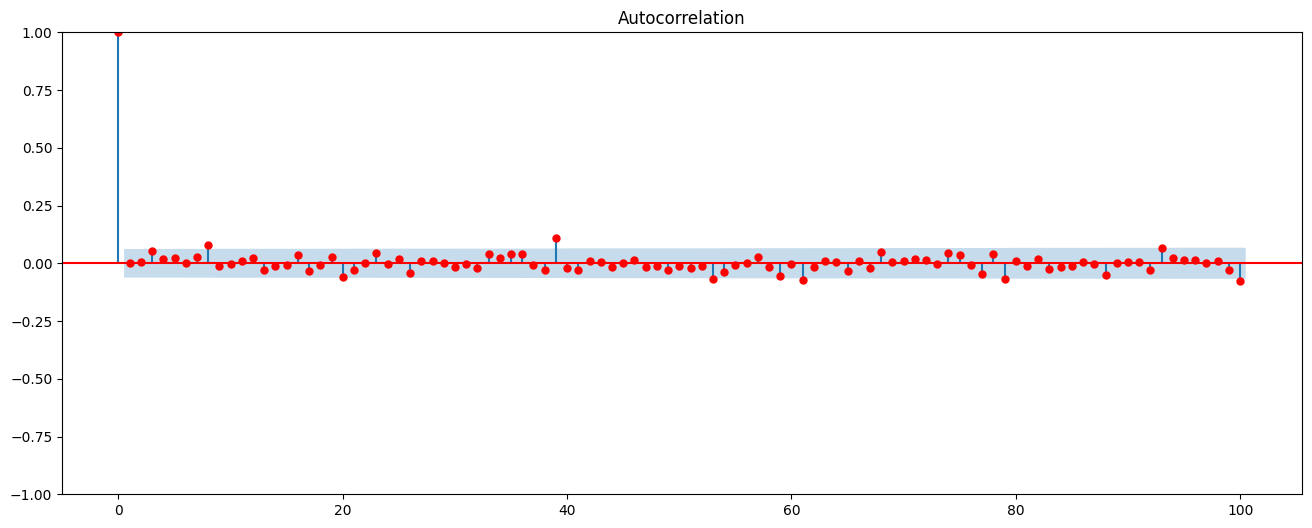

In [40]:
from statsmodels.graphics import tsaplots

X = np.random.randn(1000)
plot_acf(X, lags=100, color="red").set_size_inches(16, 6)
plt.show()

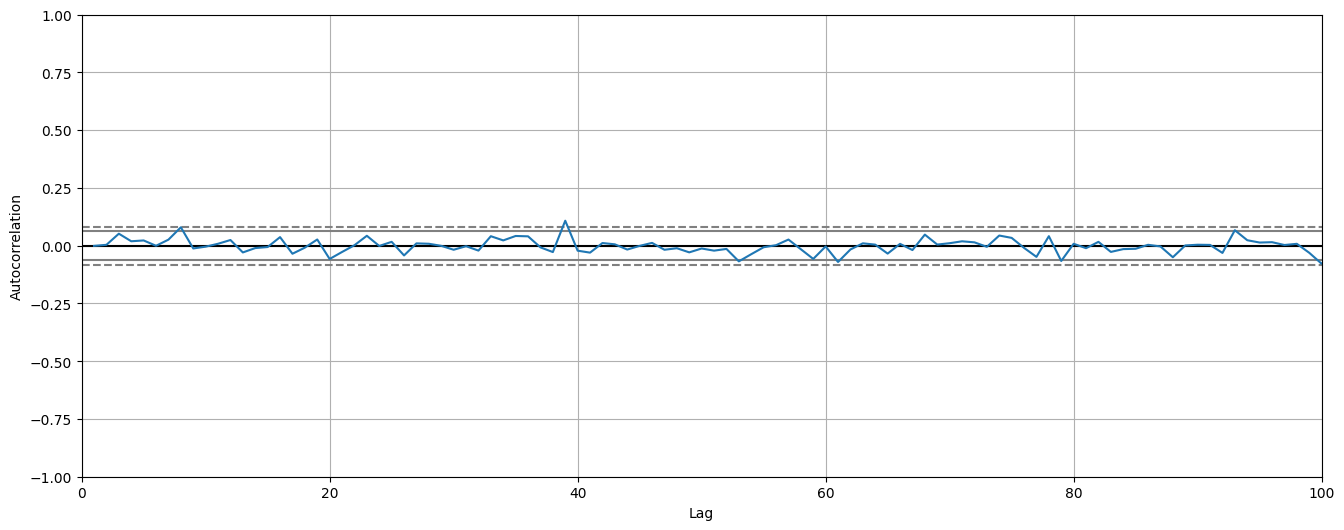

In [41]:
plt.figure(figsize=(16, 6))
pd.plotting.autocorrelation_plot(X).set_xlim([0, 100])
plt.show()

Obviously, autocorrelation at various lags hover around $0$, which is a sign of stationarity. 

Here is the correlogram of monthly urban consumers' CPI in US. Note the old tradition in econometrics is to computer ACF up to $1/3$ length of time series, we are following this rule below.

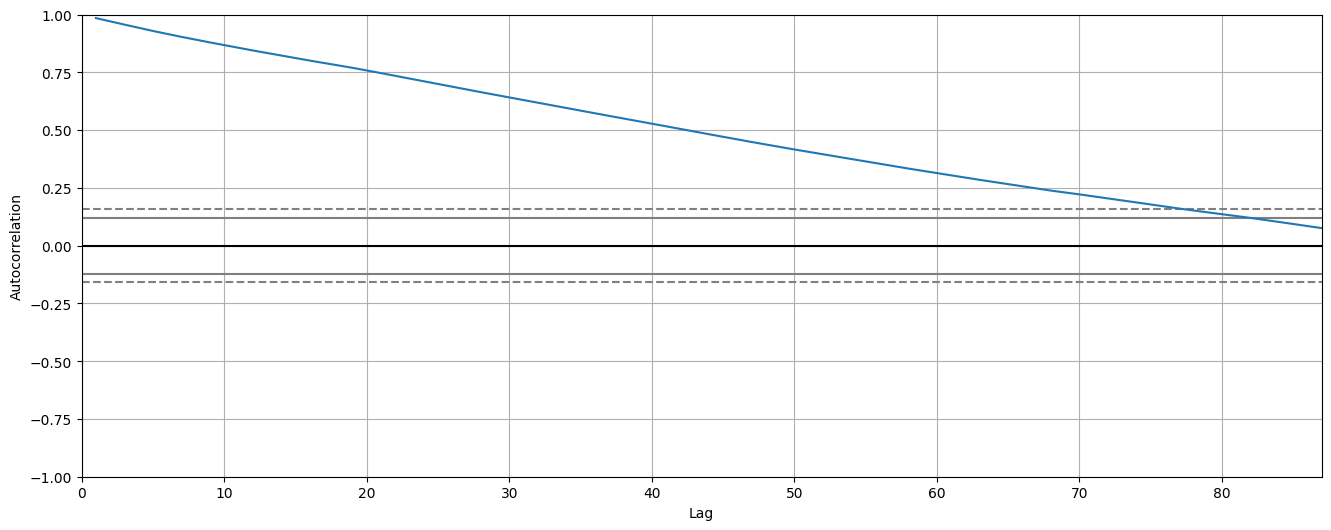

In [42]:
df = pdr.data.DataReader(["CPIAUCSL"], "fred", start, end)
df.columns = ["CPI_Urban"]

plt.figure(figsize=(16, 6))
pd.plotting.autocorrelation_plot(df["CPI_Urban"]).set_xlim([0, np.round(len(df) / 3)])
plt.show()

### <font face="gotham" color="purple"> Ljung-Box Test </font>

Apart from the _Breusch-Godfrey_ and _Durbin-Watson_ test that we have discussed in the chapter of autocorrelation, we will introduce one more common autocorrelation test in time series, **Ljung-Box Test** (LB test).
$$
\mathrm{LB}=n(n+2) \sum_{k=1}^{m}\left(\frac{\hat{\rho}_{k}^{2}}{n-k}\right) \sim \chi^{2}_m
$$

The hypotheses are
$$
H_0: \text{No autocorrelation presents}\\
H_1: \text{Autocorrelation presents for specified lags}
$$

There are many controversial debates about when and how to use these statistics, but those academic debates belong to academia, we go lightly here. LB test is group test which depends on any specification of lags. If you want to check if first $10$ lags if it shows any sign of autocorrelation, we use the code as below 

In [43]:
sm.stats.acorr_ljungbox(df["CPI_Urban"], lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,2308.449335,0.0,2244.617168,0.0


The test shows overwhelmingly evidence for autocorrelation up to lag $10$. Note that we also add ```boxpierce``` argument in the function, this is a variant of LB test, usually printed for reference.

### <font face="gotham" color="purple"> Dickey–Fuller (DF) test </font>

If we suspect that $Y_t$ follows a unit root process, why don't we simply regress $Y_t$ onto $Y_{t-1}$, i.e. 
$$
Y_{t}=\rho Y_{t-1}+u_{t} \quad-1 \leq \rho \leq 1
$$
The problem is that if $\rho=1$, the $t$-statistic is severely biased, let's simulate the process and examine if this is the case.

However, some manipulation can circumvent the issue
\begin{aligned}
Y_{t}-Y_{t-1} &=\rho Y_{t-1}-Y_{t-1}+u_{t} \\
&=(\rho-1) Y_{t-1}+u_{t}\\
\Delta Y_t &= \delta Y_{t-1}+u_{t}
\end{aligned}
where $\delta = \rho-1$. If $\delta =0$, i.e. $\rho=1$, then $\Delta Y_t = u_t$, therefore $Y_t$ is unstationary; if $\delta <0$, then $\rho <1$, in that case $y_t$ is stationary.

The last equation $\Delta Y_t = \delta Y_{t-1}+u_{t}$ is the one to estimate and hypotheses are 
$$
H_0: \delta = 0, \text{unstationary}\\
H_1: \delta < 0, \text{stationary}
$$

It turns out the $t$-statistic calculated on $\delta$ doesn't really follow a $t$-distribution, it actually follows $\tau$-distribution or **Dickey-Fuller distribution**, therefore we call it _Dickey-Fuller test_.

In [44]:
from statsmodels.tsa.stattools import adfuller

In [45]:
results_dickeyfuller = adfuller(X)
print("ADF Statistic: %f" % results_dickeyfuller[0])
print("p-value: %f" % results_dickeyfuller[1])

ADF Statistic: -31.605899
p-value: 0.000000


## <font face="gotham" color="purple"> Transforming Nonstationary Time Series </font>

In academia, unfortunately transformation of nonstationarity is still a controversial topic. Jame Hamilton argues that we should never use HP filter due to its heavy-layered differencing, i.e. the cyclical components of HP-filtered series are the fourth difference of its corresponding trend component. 

Also because most of economic and financial time series exhibit features of random walk, the cyclical components are merely artifacts of applying the filter. 

However, let's not be perplexed by sophisticated academic discussion. Here's the rule of thumb.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
<h3>HP filter or F.O.D.?</h3>
If you want to do business cycle analysis with structural macro model, use HP-filter. <br>
If you want to do ordinary time series modeling, use first order difference.
</div> 

## <font face="gotham" color="purple"> Cointegration </font>

We have seen the invalid estimated results from regression of nonstationary time series onto another nonstationary time series, which possibly would cause a spurious regression.

However, if both series share a common trend, the regression between them will not be necessarily spurious. 

In [46]:
start = dt.datetime(1980, 1, 1)
end = dt.datetime(2021, 10, 1)
df = pdr.data.DataReader(["PCEC96", "A229RX0"], "fred", start, end).dropna()
df.columns = ["real_PCE", "real_DPI"]
df.head()

,real_PCE,real_DPI
DATE,,
2007-01-01,11181.0,39803.0
2007-02-01,11178.2,39906.0
2007-03-01,11190.7,40007.0
2007-04-01,11201.5,40037.0
2007-05-01,11218.0,40029.0


In [47]:
model = smf.ols(formula="np.log(real_PCE) ~ np.log(real_DPI)", data=df)
results = model.fit()

In [48]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(real_PCE)   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     695.2
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           5.03e-63
Time:                        18:56:58   Log-Likelihood:                 323.03
No. Observations:                 178   AIC:                            -642.1
Df Residuals:                     176   BIC:                            -635.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.8270      0.389  

In [49]:
dickey_fuller = adfuller(results.resid)
print("ADF Statistic: %f" % dickey_fuller[0])
print("p-value: %f" % dickey_fuller[1])

ADF Statistic: -2.557685
p-value: 0.102062


Note that we are able to reject null hypothesis of nonstationarity with $5\%$ siginificance level.

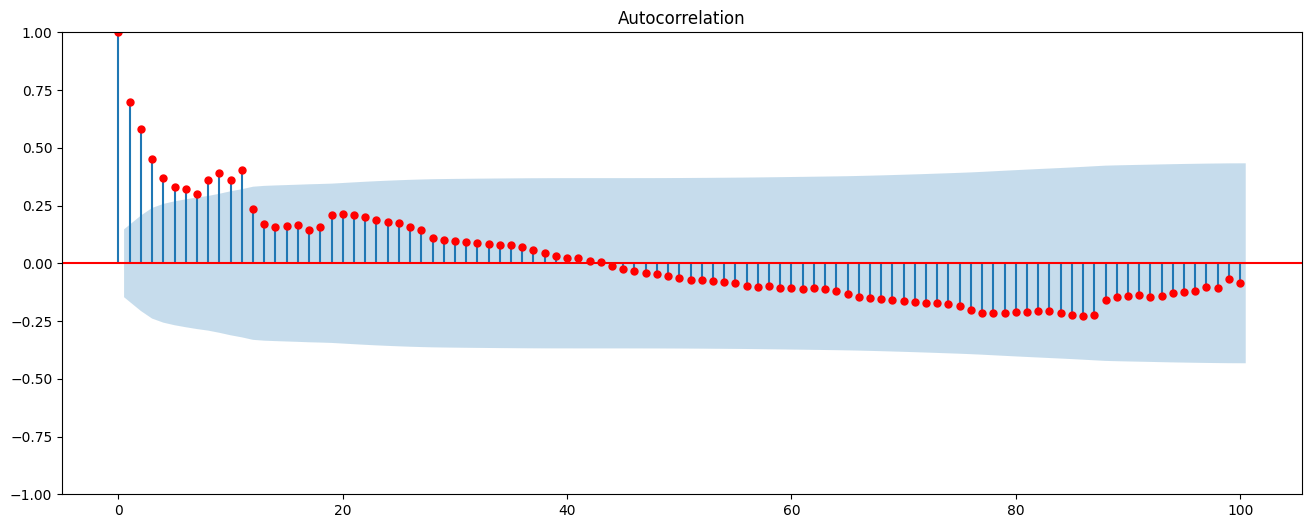

In [50]:
plot_acf(results.resid, lags=100, color="red").set_size_inches(16, 6)

The disturbance terms can be seen as a linear combination of $PCE$ and #DPI#
$$
u_{t}=\ln{PCE}_{t}-\beta_{1}-\beta_{2} \ln{DPI}_{t}
$$
If both variables are $I(1)$, but residuals are $I(0)$, we say that the two variables are **cointegrated**, the regression is also known as **cointegrating regression**. Economically speaking, two variables will be cointegrated if they have a long-term, or equilibrium, relationship between them. 

One of the key considerations prior to testing for cointegration, is whether there is theoretical support for the cointegrating relationship.  It is important to remember that cointegration occurs when separate time series share an underlying stochastic trend. The idea of a shared trend should be supported by economic theory.

One thing to note here, in cointegration context, we usually perform a **Engle–Granger** (EG) or **augmented Engle–Granger** (AEG) test, they are essential DF test, 

$$
H_0: \text{No cointegration}\\
H_1: \text{Cointegreation presents}
$$

In [51]:
from statsmodels.tsa.stattools import coint

coint_test1 = coint(df["real_PCE"], df["real_DPI"], trend="c", autolag="BIC")
coint_test2 = coint(df["real_PCE"], df["real_DPI"], trend="ct", autolag="BIC")

In [52]:
def coint_output(res):
    output = pd.Series(
        [res[0], res[1], res[2][0], res[2][1], res[2][2]],
        index=[
            "Test Statistic",
            "p-value",
            "Critical Value (1%)",
            "Critical Value (5%)",
            "Critical Value (10%)",
        ],
    )
    print(output)

Without linear trend.

In [53]:
coint_output(coint_test1)

Test Statistic         -2.654047
p-value                 0.216540
Critical Value (1%)    -3.959385
Critical Value (5%)    -3.370868
Critical Value (10%)   -3.068498
dtype: float64


With linear trend.

In [54]:
coint_output(coint_test2)

Test Statistic         -3.475462
p-value                 0.104927
Critical Value (1%)    -4.415983
Critical Value (5%)    -3.834688
Critical Value (10%)   -3.536555
dtype: float64


## <font face="gotham" color="purple"> Error Correction Mechanism </font>

**Error Correction Mechanism** (ECM) is an phenomenon that any variable deviates from its equilibrium will correct its own error gradually.

$$
u_{t-1}=\ln{PCE}_{t-1}-\beta_{1}-\beta_{2} \ln{DPI}_{t-1}
$$
$$
\Delta \ln{PCE}_{t}=\alpha_{0}+\alpha_{1} \Delta \ln{DPI}_{t}+\alpha_{2} \mathrm{u}_{t-1}+\varepsilon_{t}
$$

Suppose $u_{t-1}> 0$ and $\Delta DPI_t =0$, it means $PCE_t$ is higher than equilibrium. In order to correct this temporary error, $\alpha_2$ has to be negative to adjust back to the equilibrium, hence $\Delta \ln{PCE_t}<0$.

We can get $u_{t-1}$ by $\hat{u}_{t-1}$
$$
\hat{u}_{t-1}=\ln{PCE}_{t-1}-\hat{\beta}_{1}-\hat{\beta}_{2} \ln{DPI}_{t-1}
$$

In [55]:
df_new = {
    "Delta_ln_PCE": df["real_PCE"].diff(1),
    "Delta_ln_DPI": df["real_DPI"].diff(1),
    "u_tm1": results.resid.shift(-1),
}
df_new = pd.DataFrame(df_new).dropna()
df_new

,Delta_ln_PCE,Delta_ln_DPI,u_tm1
DATE,,,
2007-02-01,-2.8,103.0,-0.027025
2007-03-01,12.5,101.0,-0.026780
2007-04-01,10.8,30.0,-0.025116
2007-05-01,16.5,-8.0,-0.023751
2007-06-01,0.5,-55.0,-0.020933
...,...,...,...
2021-05-01,-41.1,-1509.0,0.032356
2021-06-01,126.8,-262.0,0.024824
2021-07-01,-32.4,281.0,0.033059


In [56]:
model_ecm = smf.ols(formula="Delta_ln_PCE ~ Delta_ln_DPI + u_tm1", data=df_new)
results_ecm = model_ecm.fit()
print(results_ecm.summary())

                            OLS Regression Results                            
Dep. Variable:           Delta_ln_PCE   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     12.03
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.29e-05
Time:                        18:56:59   Log-Likelihood:                -1142.7
No. Observations:                 176   AIC:                             2291.
Df Residuals:                     173   BIC:                             2301.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       21.5258     12.159      1.770   